In [1]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
import pandas as pd
import statsmodels.tsa.api as tsa


# 1. Simplest benchmarking dataset
Data from https://causeme.uv.es/model/linear-VAR/

Properties: Time series, Synthetic,	Autocorrelation, time delays, linear


In [2]:
# Initialize dataframe object, specify time axis and variable names
df = pd.read_csv('/home/chrei/Dropbox/uni/causal_inference/causeme_python_example/experiments/linear-VAR_N-3_T-300/linear-VAR_N-3_T-300_0001.txt', sep=" ", header=None)
df -= df.mean(axis=0)
df /= df.std(axis=0)

df.head()

,0,1,2
0,1.894575,-0.328880,-0.464295
1,-1.074359,0.137193,0.713364
2,-1.294727,0.782376,0.757053
3,-0.341782,1.291537,1.367696
4,-0.127392,1.230834,0.057129


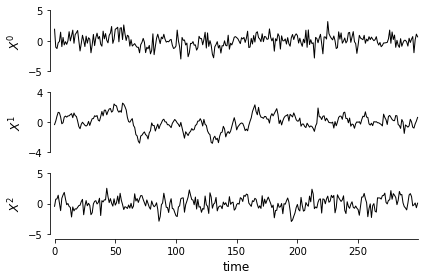

In [3]:
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(df.values, datatime = np.arange(len(df)),
                         var_names=var_names)

tp.plot_timeseries(dataframe); plt.show()

conditional independence test: ``ParCorr`` implementing linear partial correlation due to known linearity of the dataset.
With ``significance='analytic'`` the null distribution is assumed to be Student's $t$.
Initialize the ``PCMCI`` method with  ``dataframe``, and ``cond_ind_test``.
plot the lagged unconditional dependencies, e.g., the lagged correlations.



##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 11


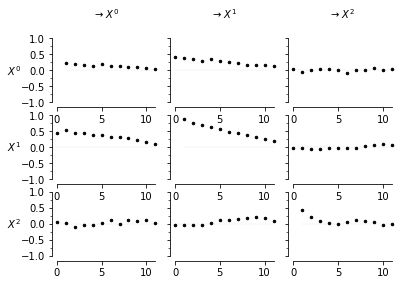

In [4]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=1)

correlations = pcmci.get_lagged_dependencies(tau_max=11, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names,
                                    'x_base':5, 'y_base':.5}); plt.show()

dependencies decay beyond a maximum lag of around 11 -> ``tau_max=11``. Update: after I found out it probably doesn't work I cheated and changed it to 5 because thats the true max lag. Spoiler: I think it still doesn't work.
``pc_alpha=None``: PCMCI optimizes the significance level in the condition-selection step (in the ParCorr case by the Akaike Information criterion).

In [5]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=5, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 4 link(s):
    [pc_alpha = 0.5]
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.327
        ($X^2$ -2): max_pval = 0.07445, min_val = -0.105
        ($X^1$ -2): max_pval = 0.31096, min_val = -0.060
        ($X^1$ -3): max_pval = 0.47546, min_val =  0.042

    Variable $X^1$ has 3 link(s):
    [pc_alpha = 0.05]
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.630
        ($X^0$ -4): max_pval = 0.00284, min_val =  0.175
        ($X^2$ -5): max_pval = 0.03089, min_val =  0.127

    Variable $X^2$ has 2 link(s):
    [pc_alpha = 0.2]
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.400
        ($X^0$ -1): max_pval = 0.17860, min_val = -0.079

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par

PCMCI selected ``0.4, 0.4, and 0.5 for pc_alpha``.

optionally its confidence bounds (can be specified upon initializing ``ParCorr``).
``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry ``(i, j, \tau)`` denoting the test for the link $X^i_{t-\tau} \to X^j_t$.
The MCI values for $\tau=0$ do not exclude other contemporaneous effects, only past variables are conditioned upon.

In [6]:
print("p-values")
print (results['p_matrix'].round(3))
print("\nMCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.357 0.242 0.475 0.529 0.856]
  [0.318 0.729 0.34  0.578 0.025 0.527]
  [0.281 0.099 0.204 0.243 0.808 0.925]]

 [[0.318 0.    0.028 0.059 0.543 0.377]
  [1.    0.    0.79  0.806 0.754 0.255]
  [0.805 0.755 0.621 0.16  0.982 0.727]]

 [[0.281 0.071 0.047 0.412 0.543 0.804]
  [0.805 0.775 0.949 0.763 0.723 0.   ]
  [1.    0.    0.579 0.921 0.857 0.416]]]

MCI partial correlations
[[[ 0.    0.05 -0.07 -0.04 -0.04 -0.01]
  [-0.06 -0.02  0.06 -0.03  0.13 -0.04]
  [ 0.06 -0.1   0.08  0.07  0.01 -0.01]]

 [[-0.06  0.32 -0.13  0.11 -0.04  0.05]
  [ 0.    0.63  0.02  0.01  0.02  0.07]
  [-0.01 -0.02  0.03 -0.08  0.    0.02]]

 [[ 0.06  0.11 -0.12  0.05 -0.04 -0.01]
  [-0.01 -0.02 -0.   -0.02 -0.02  0.21]
  [ 0.    0.41  0.03  0.01 -0.01 -0.05]]]


correct the p-values by False Discovery Rate (FDR) control yielding the ``q_matrix``.
Print the detected parents of each variable at a chosen significance level of 0.05:

In [7]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=5, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable $X^0$ has 1 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.317

    Variable $X^1$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.633
        ($X^2$ -5): pval = 0.00037 | qval = 0.00411 | val =  0.209

    Variable $X^2$ has 1 link(s):
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.407


create boolean matrix of significant links from the p-/q-matrix and choosing ``alpha_level =0.05``.

In [8]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

Process graph:
node color: auto-MCI value
link colors: cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

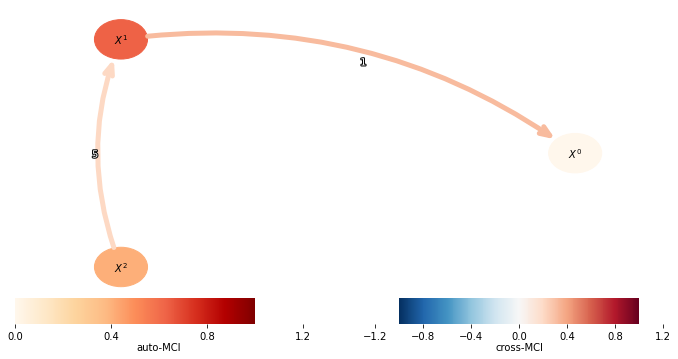

In [9]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    figsize=(10, 6),
    ); plt.show()

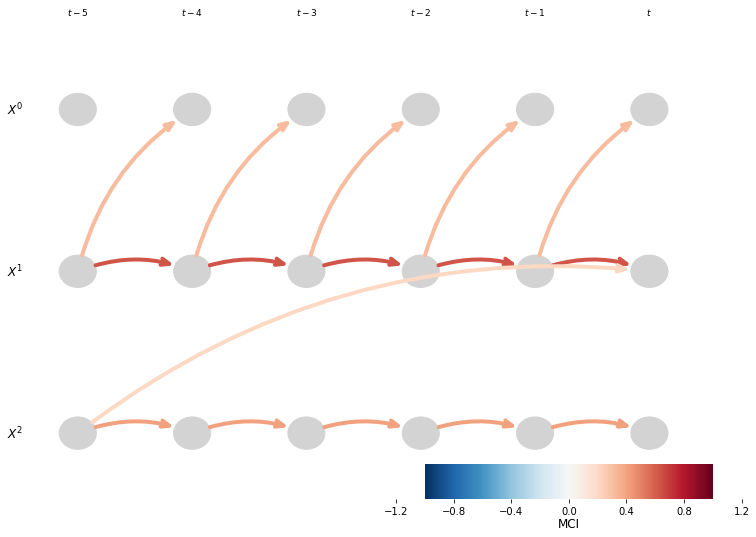

In [10]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(12, 8),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

# Simulate simplest to have an available ground truth
3 nodes, autocorrelation, max lag of 2, noise?, few links, linear, no missing values, no aggregation ,no subsampling, ...
\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-2} + \eta^0_t\\
X^1_t &= 0.8 X^2_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + \eta^2_t\\
\end{align*}

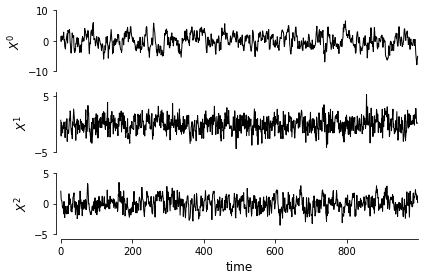

In [11]:
links_coeffs = {0: [((0, -1), 0.7), ((1, -2), -0.8)],
                1: [((2, -1), 0.8)],
                2: [((2, -1), 0.5)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data,
                         datatime = np.arange(len(data)),
                         var_names=var_names)

# plot
tp.plot_timeseries(dataframe); plt.show()

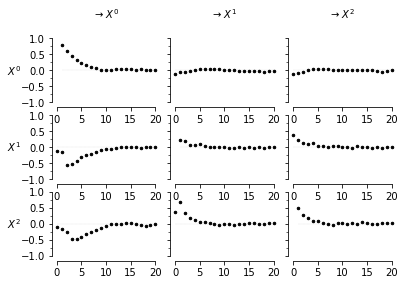

In [12]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=0)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names,
                                    'x_base':5, 'y_base':.5}); plt.show()

In [13]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=15, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 15
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 9 link(s):
    [pc_alpha = 0.5]
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.633
        ($X^1$ -2): max_pval = 0.00000, min_val = -0.566
        ($X^2$ -2): max_pval = 0.03602, min_val =  0.067
        ($X^2$ -10): max_pval = 0.29252, min_val =  0.034
        ($X^0$ -12): max_pval = 0.31227, min_val =  0.032
        ($X^2$ -5): max_pval = 0.32682, min_val =  0.032
        ($X^1$ -5): max_pval = 0.34958, min_val =  0.030
        ($X^1$ -3): max_pval = 0.37958, min_val = -0.028
        ($X^1$ -10): max_pval = 0.44256, min_val = -0.025

    Variable $X^1$ has 3 link(s):
    [pc_alpha = 0.2]
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.618
        ($X^1$ -2): max_pval = 0.12294, min_val =  0.050
        

In [14]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=15, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'],
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | qval = 0.00000 | val = -0.600
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.582

    Variable $X^1$ has 1 link(s):
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.614

    Variable $X^2$ has 1 link(s):
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.445


at first clance it looks perfectly like datagenerating process (shown below, again). Only the link strength got weaker.
\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-2} + \eta^0_t\\
X^1_t &= 0.8 X^2_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + \eta^2_t\\
\end{align*}

plot:

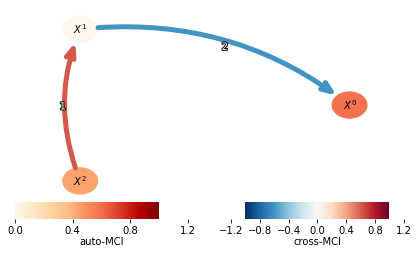

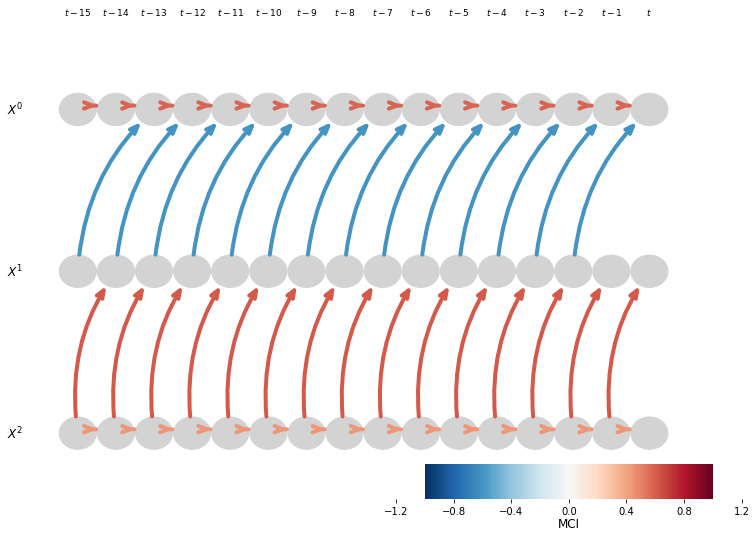

In [15]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']
# process graph
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(12, 8),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

# More difficult simulated dataset
5 nodes, max lag of 5, 10 links

\begin{align*}
X^0_t &= 0.9 X^0_{t-1} + 0.9 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^2_{t-2} + \eta^1_t\\
X^2_t &= 0.7 X^2_{t-1} + 0.7 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.6 X^3_{t-1} + 0.6 X^4_{t-4}+ \eta^3_t\\
X^4_t &= 0.5 X^4_{t-1} - 0.4 X^4_{t-5}+ \eta^4_t\\
\end{align*}


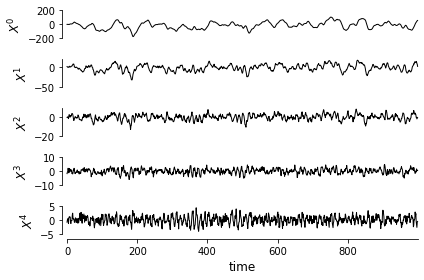

In [16]:
np.random.seed(42)     # Fix random seed

links_coeffs = {0: [((0, -1), 0.9), ((1, -1), 0.9)],
                1: [((1, -1), 0.8), ((2, -2), 0.8)],
                2: [((2, -1), 0.7), ((3, -3), 0.7)],
                3: [((3, -1), 0.6), ((4, -4), 0.6)],
                4: [((4, -1), 0.5), ((4, -5), -0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$', r'$X^4$']
dataframe = pp.DataFrame(data,
                         datatime = np.arange(len(data)),
                         var_names=var_names)

tp.plot_timeseries(dataframe); plt.show()

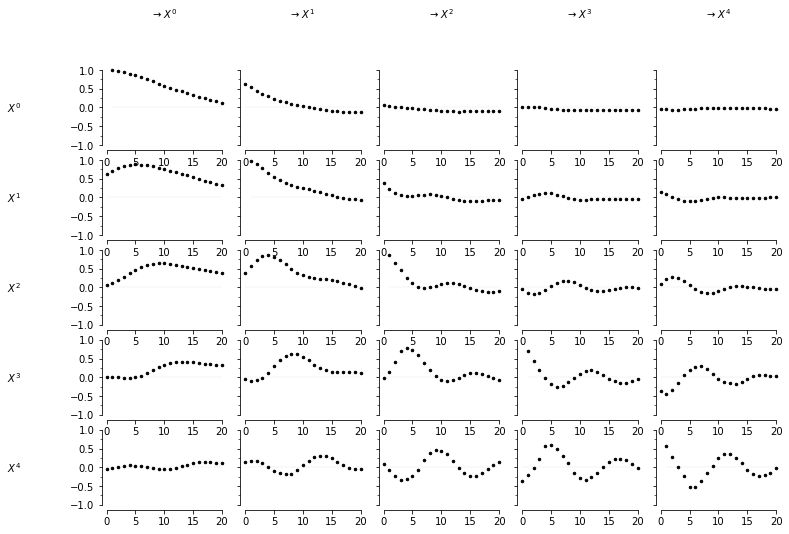

In [17]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=0)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']

lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names,'x_base':5, 'y_base':.5,    'figsize':(12, 8)}); plt.show()


## Significant links at alpha = 0.05:

    Variable $X^0$ has 3 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.655
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.654
        ($X^3$ -15): pval = 0.00035 | qval = 0.01099 | val = -0.115

    Variable $X^1$ has 2 link(s):
        ($X^2$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.630
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.618

    Variable $X^2$ has 2 link(s):
        ($X^3$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.563
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.551

    Variable $X^3$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.531
        ($X^4$ -4): pval = 0.00000 | qval = 0.00000 | val =  0.481

    Variable $X^4$ has 3 link(s):
        ($X^4$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.430
        ($X^4$ -5): pval = 0.00000 | qval = 0.00000 | val = -0.304
        ($X^3$ -4): pval = 0.00020 | qval = 0.00

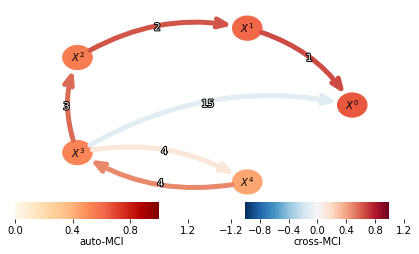

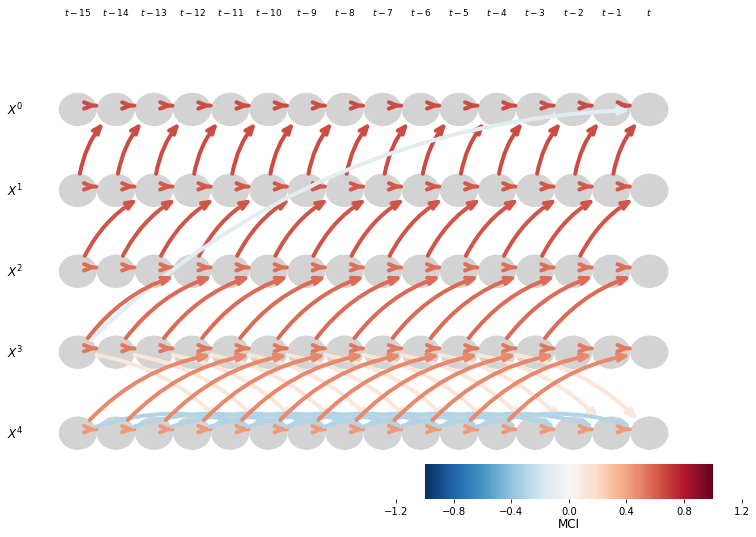

In [18]:
pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=15, pc_alpha=None)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=15, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'],
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)

link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']
# process graph
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(12, 8),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

false positives but no false negatives -> maybe significance lefel is too high -> trying with lower alpha


## Significant links at alpha = 0.001:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.655
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.654

    Variable $X^1$ has 2 link(s):
        ($X^2$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.630
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.618

    Variable $X^2$ has 2 link(s):
        ($X^3$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.563
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.551

    Variable $X^3$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.531
        ($X^4$ -4): pval = 0.00000 | qval = 0.00000 | val =  0.481

    Variable $X^4$ has 2 link(s):
        ($X^4$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.430
        ($X^4$ -5): pval = 0.00000 | qval = 0.00000 | val = -0.304


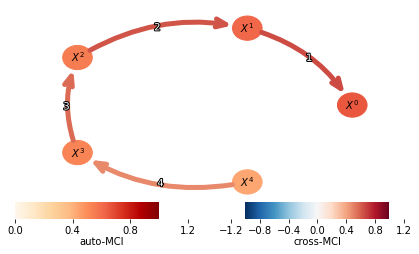

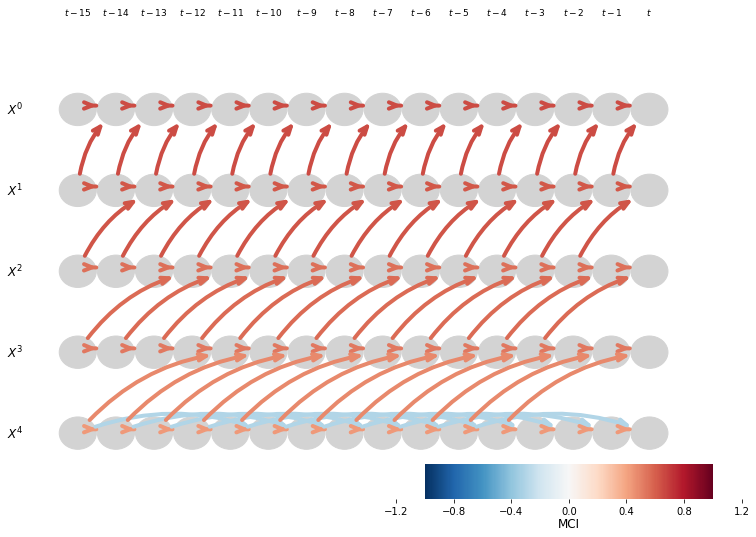

In [19]:
alpha_level = 0.001
pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=15, pc_alpha=None)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=15, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'],
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = alpha_level)

link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=alpha_level)['link_matrix']
# process graph
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(12, 8),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

now it's correct, but manual adjustment of significance level isn't cool. I wonder if it can be automated or if a lower one is always favorable.